# GEDI Level 2B Vertical Plant Profiles - Dask Integration Test

This notebook compares performance of pygedi numpy and dask.array backends for retrieving vertical plant profiles. The GEDI Level 2B product provides vertical cover, plant area index (PAI) and plant area volume density (PAVD) profiles at a vertical resolution of 5 m. In the following we retrieve the directional gap probability (Pgap) profile from the Level 2B product using GEDIPy with a dask backend, compute these vertical profile metrics at the vertical resolution of the original Level 1B waveform, and then visualize them.

In [1]:
import pandas

import matplotlib.pyplot as plt
import ipywidgets

from gedipy import h5io
from dask import delayed, compute, visualize, config
from dask.distributed import Client
import dask.array as da
import dask
import numpy as np

from numba import prange
from numba import jit
%load_ext memory_profiler

### Check dask global settings

First, we check the gloabl chunk size definition. This size is used when calling `chunks="auto"`

In [2]:
config.get('array.chunk-size')

'128MiB'

Working on a Laptop with `dask.Arrays` or `numpy.ndarrays` we make sure the sheduler is set to `'threads'`

In [3]:
# dask.config.set(scheduler='threads')

When using `dask.distributed` in order to use a threaded sheduler you can use the `processes=False` argument. The dask client helps to set up a dask dashboard. After running the next lines you can click on the provided link to monitor code performance on your system.

In [4]:
client = Client(processes=False)
client

Client Scheduler: inproc://10.0.2.15/3805/1 Dashboard: http://10.0.2.15:8787/status,Cluster Workers: 1 Cores: 2 Memory: 4.13 GB


## A function to recompute vertical profiles
We need datasets from the Level 2B file to compute the zenith angle of laser shot and also ancillary metrics including the RossG coefficent (canopy element projection function) and Omega coefficient (clumping factor)

In [5]:
def get_vertical_profiles(pgap_theta_z, height, local_beam_elevation, rossg, omega):
    cos_zenith = numpy.abs( numpy.sin(local_beam_elevation) )
    cover_z = cos_zenith * (1.0 - pgap_theta_z)
    pai_z = -(1.0 / (rossg * omega)) * numpy.log(pgap_theta_z) * cos_zenith
    pavd_z = -numpy.gradient(pai_z, height)       
    return cover_z, pai_z, pavd_z

## Open the H5 file
We select one of the power beams for this example

In [6]:
file_path_2B = "/home/stef/Testbed/00_data/GEDI/GEDI02_B_2019113083317_O02042_T04038_02_001_01.h5"

In [7]:
%%memit 
l2b_f = h5io.GEDIH5File(file_path_2B)

peak memory: 237.34 MiB, increment: 0.07 MiB


In [9]:
with l2b_f.open_h5() as f:
    l2b_f = f.read()
    l2b_f.beams()

AttributeError: 'File' object has no attribute 'open_h5'

## Read all the profiles for one beam
This remaps the 1D pgap_theta_z array to a 2D M x N array, where M is the number Pgap profiles bins and N is the number of GEDI shots

### 1. Use of dask.delayed()?

First it is worth checking if a simple `dask.delayed()` call can be applied to current functionality in order to compute results lazily.

In [9]:
# Params
minlength=None
height=False #True
start_offset = 2
start=1
finish=None
chunks={"1":2048,"2":4096,"3":"auto"}
beam = 'BEAM1011'

In [10]:
pgap_theta_z_da = delayed(l2b_f.read_pgap_theta_z)(beam, start=start, finish=finish, start_offset=start_offset)

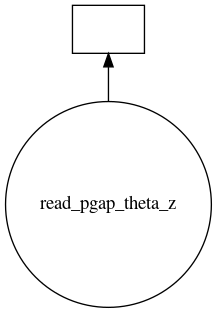

In [11]:
pgap_theta_z_da.visualize()

Inspecting the task graph reveals, as expected, that simply packing the funciton into a delayed call does not guarantee it beeing executed in parallel. Wrapping the current state of the function only has one delayed task, and so cannot parallelize. Ideally it woudl have ot be rewritten in smaller tasks, i.e. load data, process data and save data.

Let's now profile both versions. We can compare the output of `%memit`, as well as have a look at the Dashboard displaying `Dask: Status`.

In [12]:
%%memit 
pgap_theta_z_da.compute()

peak memory: 1596.19 MiB, increment: 1353.89 MiB


In [14]:
#%%memit
%%%mprun
# start_offset is used to buffer the start of the profile with pgap_theta_z = 1
pgap_theta_z = l2b_f.read_pgap_theta_z(beam, start=start, finish=finish, height=height, start_offset=start_offset)

peak memory: 1619.90 MiB, increment: 1399.48 MiB


As we can see both versions peak around  1600 MiB in memory, they basically perform the same. However, monitoring the dask dashboard reveales, that after calling dask delayed. Bytes stored returns back to 228 MB, while a normal function call now stores 1.6GB in Memory.

The advantage of using dask.delayed here is that stored data is automatically removed from memory, which is beneficial for continuing with other memory intensive computations.


### 2. Refactoring the code to make use of `dask.arrays`

In [20]:
    @jit(nopython=True)# Not working wiht parallel=True
    def _waveform_1d_to_2d_test(start_indices, counts, data, out_data, start_offset=0):
        for i in prange(start_indices.shape[0]):
            for j in prange(counts[i]):
                out_data[j+start_offset, i] = data[start_indices[i] + j]
        return out_data
    
    
    def _expand(pgap):
            return np.expand_dims(pgap, axis=0)
    
    
    def _access_data(beam, key, start, finish, chunks):
        darr = da.from_array(l2b_f.fid[
            beam+key][start:finish], chunks=chunks)
        return darr
    
    
    def load_data(l2b_f, finish=None):
    
        if not finish:
            finish = len(l2b_f.fid[beam+'/rx_sample_start_index'])

        start_indices_da = da.from_array(l2b_f.fid[
            beam+'/rx_sample_start_index'][start:finish]-1, chunks=chunks)
        counts_da = _access_data(beam=beam, key='/rx_sample_count', start=start,
                               finish=finish, chunks=chunks)
        pgap_da = _access_data(beam=beam, key='/pgap_theta', start=start,
                               finish=finish, chunks=chunks)
        
        max_count_da = counts_da.max() + start_offset
        x_da = da.map_blocks(_expand, pgap_da)
        
        start_indices, counts, max_count, x = compute(start_indices_da,
                                                      counts_da, max_count_da,
                                                      x_da)
        return start_indices, counts, max_count, x
    
    
    def read_pgap_theta_z_dask(l2b_f, beam, start=0, finish=None, minlength=None,
                          height=False, start_offset=0, 
                          chunks={"1":"auto","2":"auto","3":"auto"}):
        """
        Remap the 1D pgap_theta_z array to a 2D M x N array, where M is
        the number Pgap profiles bins and N is the number of GEDI shots
        
        Parameters
        ----------
        beam: str
            Name of beam assessed, i.e. 'BEAM0001'
        start: int
            start of np.ndarray like slicing, Default=0
        finish: int/ None
            end of np.ndarray like slicing, Default=None
        minlength:
            TBD, Default=None
        height: bool
            TBD
        start_offset: str
            TBD
        
        Returns
        -------
        out_pgap_profile: numpy.ndarray
            TBD
        out_height:
            TBD
        """
        
        start_indices, counts, max_count, x = load_data(l2b_f, finish=finish)
        
        pgap_profile_da = da.from_array(l2b_f.fid[beam+'/pgap_theta_z'][
            start_indices[0]:(start_indices[-1]+counts[-1])], chunks=chunks)

        if minlength:
            max_count = max(minlength, max_count)
            
        out_shape = (max_count, len(counts))

        out_pgap_profile_da = da.ones(out_shape, dtype=pgap_profile_da.dtype,
                                     chunks=chunks)
        out_pgap_profile_da = out_pgap_profile_da * x
        
        z = da.ones(out_pgap_profile_da[0:start_offset,:].shape,
                   chunks=chunks)
        out_pgap_profile_da = da.concatenate([
            z, out_pgap_profile_da[start_offset:,:]], axis=0)
        
        start_indices_wv = start_indices - start_indices.min()
        
        pgap_profile, out_pgap_profile = compute(
            pgap_profile_da, out_pgap_profile_da)
        
        pgap_profile_out = delayed(_waveform_1d_to_2d_test)(start_indices_wv,
                                              counts, pgap_profile,
                                              out_pgap_profile,
                                              start_offset=start_offset)
        
        if height is True:
            height_bin0 = _access_data(beam=beam, key='/geolocation/height_bin0',
                                       start=start, finish=finish, chunks=chunks)
            height_lastbin = _access_data(beam=beam, key='/geolocation/height_lastbin',
                                       start=start, finish=finish, chunks=chunks)
            v = (height_bin0 - height_lastbin) / (counts - 1)

            bin_dist = da.arange(max_count).reshape([-1,1])
            x_height = da.map_blocks(_expand, height_bin0)
            y = da.repeat(bin_dist, len(v), axis=1)
            out_height = x_height-y * v + start_offset * v
            out_height

            return pgap_profile_out.compute(), out_height.compute()
        
        else:
            return pgap_profile_out.compute()

In [31]:
# Params
minlength=None
height=True
start_offset = 2
start=1
finish=800000
chunks={"1":100,"2":100,"3":"auto"}

In [ ]:
%%memit
pgap_theta_z_dask, out_height_dask = read_pgap_theta_z_dask(l2b_f, beam, start=start, finish=finish, height=height, start_offset=start_offset)

In [30]:
%%memit
# start_offset is used to buffer the start of the profile with pgap_theta_z = 1
pgap_theta_z, out_height = l2b_f.read_pgap_theta_z(beam, start=start, finish=finish, height=height, start_offset=start_offset)

peak memory: 288.40 MiB, increment: 0.05 MiB


In [25]:
pgap_theta_z.shape

(278, 2999)

In [26]:
pgap_theta_z_dask.shape

(278, 2999)

In [27]:
if pgap_theta_z.all() == pgap_theta_z_dask.all():
    print("Results are the same")

Results are the same


In [28]:
if out_height.all() == out_height_dask.all():
    print("Results are the same")

Results are the same


## Step through one by one

In [9]:
if not finish:
    finish = len(l2b_f.fid[beam+'/rx_sample_start_index'])
finish

150000

In [10]:
start_indices_da = da.from_array(l2b_f.fid[
    beam+'/rx_sample_start_index'][start:finish]-1, chunks=chunks)
counts_da = da.from_array(l2b_f.fid[beam+'/rx_sample_count'][
    start:finish], chunks=chunks)
pgap_da = da.from_array(l2b_f.fid[beam+'/pgap_theta'][start:finish],
                       chunks=chunks)

max_count_da = counts_da.max() + start_offset
x_da = da.map_blocks(_expand, pgap_da)

In [11]:
counts_da

dask.array<array, shape=(113706,), dtype=int64, chunksize=(113706,), chunktype=numpy.ndarray>

In [12]:
pgap_da

dask.array<array, shape=(113706,), dtype=float32, chunksize=(113706,), chunktype=numpy.ndarray>

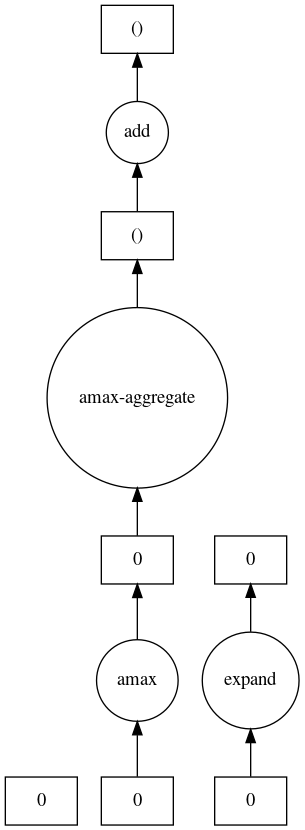

In [13]:
visualize(start_indices_da,counts_da, max_count_da, x_da)

In [14]:
start_indices, counts, max_count, x = compute(start_indices_da,
                                              counts_da, max_count_da,
                                              x_da)

In [15]:
pgap_profile_da = da.from_array(l2b_f.fid[beam+'/pgap_theta_z'][
            start_indices[0]:(start_indices[-1]+counts[-1])])
pgap_profile_da

dask.array<array, shape=(5275442,), dtype=float32, chunksize=(5275442,), chunktype=numpy.ndarray>

In [16]:
if minlength:
    max_count = max(minlength, max_count)
            
out_shape = (max_count, len(counts))

In [17]:
out_shape

(1003, 113706)

In [18]:
out_pgap_profile_da = da.ones(out_shape, dtype=pgap_profile_da.dtype)
out_pgap_profile_da.shape

(1003, 113706)

In [19]:
out_pgap_profile_da

dask.array<ones, shape=(1003, 113706), dtype=float32, chunksize=(1003, 18951), chunktype=numpy.ndarray>

In [20]:
out_pgap_profile_da = out_pgap_profile_da * x

In [21]:
z = da.ones(out_pgap_profile_da[0:start_offset,:].shape)
out_pgap_profile_da = da.concatenate([z, out_pgap_profile_da[start_offset:,:]], axis=0)
out_pgap_profile_da.shape 

(1003, 113706)

In [22]:
start_indices_wv_da = start_indices_da - start_indices_da.min()

In [23]:
start_indices_wv, pgap_profile, out_pgap_profile = compute(
    start_indices_wv_da, pgap_profile_da, out_pgap_profile_da)

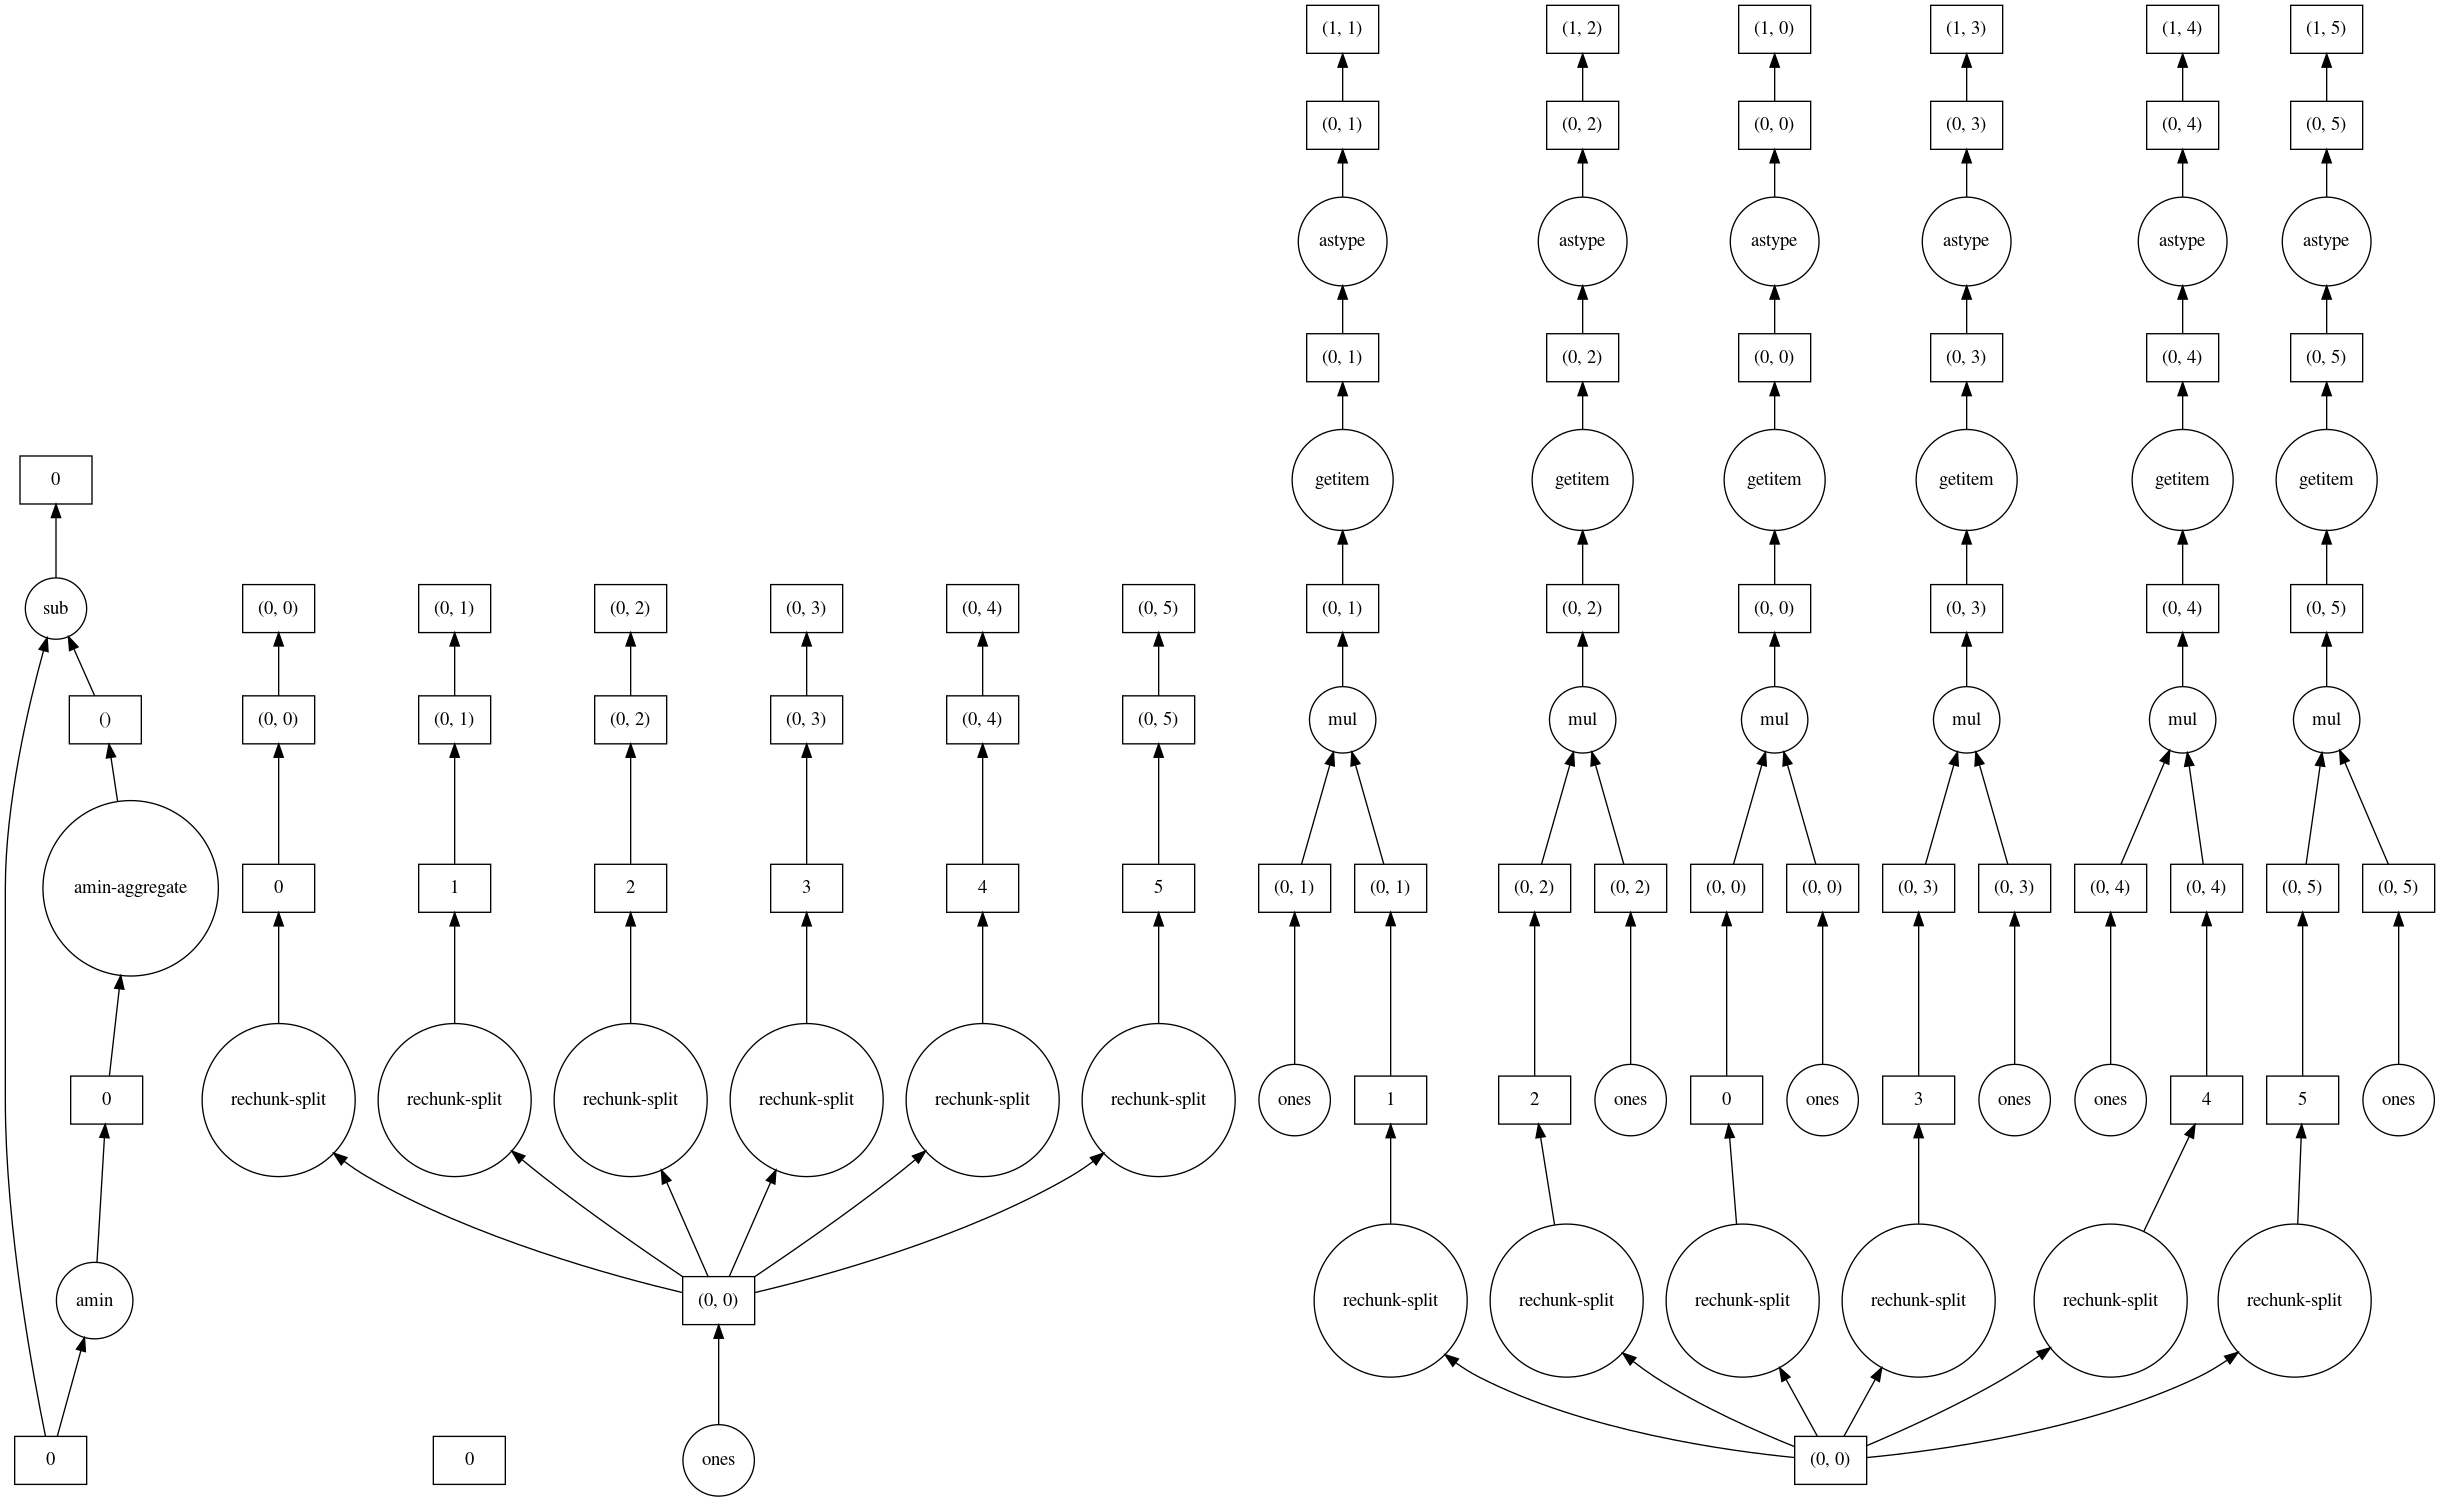

In [24]:
visualize(start_indices_wv_da, pgap_profile_da, out_pgap_profile_da)

In [25]:
from numba import jit

In [26]:
    @jit(nopython=True)#, parallel=True)
    def _waveform_1d_to_2d_test(start_indices, counts, data, out_data, start_offset=0):
        for i in prange(start_indices.shape[0]):
            for j in prange(counts[i]):
                out_data[j+start_offset, i] = data[start_indices[i] + j]
        return out_data

In [27]:
out_data = _waveform_1d_to_2d_test(start_indices_wv, counts, pgap_profile,
                               out_pgap_profile, start_offset=start_offset)

In [28]:
out_data

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.06944166, 0.08630981, 0.08825831, ..., 0.98750669, 0.99628764,
        0.99597663],
       [0.06944166, 0.08630981, 0.08825831, ..., 0.98750669, 0.99628764,
        0.99597663],
       [0.06944166, 0.08630981, 0.08825831, ..., 0.98750669, 0.99628764,
        0.99597663]])

## PROBLEM with Height

In [14]:
from dask.distributed import Client

client = Client(n_workers=4)

In [9]:
pgap_theta_z = l2b_f.read_pgap_theta_z(beam, height=height, start_offset=start_offset)

In [10]:
start=0
finish=None

In [11]:
    height_bin0 = da.from_array(l2b_f.fid[
        beam+'/geolocation/height_bin0'][start:finish],
                                chunks=chunks)
    height_lastbin = da.from_array(l2b_f.fid[
        beam+'/geolocation/height_lastbin'][start:finish],
                                  chunks=chunks)
    counts_da = da.from_array(l2b_f.fid[beam+'/rx_sample_count'][
    start:finish], chunks=chunks)

In [12]:
height_bin0 

dask.array<array, shape=(343171,), dtype=float32, chunksize=(343171,), chunktype=numpy.ndarray>

In [13]:
v = (height_bin0 - height_lastbin) / (counts_da - 1)

In [14]:
height= True
if height is True:
    height_bin0 = da.from_array(l2b_f.fid[
        beam+'/geolocation/height_bin0'][start:finish],
                                chunks=chunks)
    height_lastbin = da.from_array(l2b_f.fid[
        beam+'/geolocation/height_lastbin'][start:finish],
                                  chunks=chunks)
    counts_da = da.from_array(l2b_f.fid[beam+'/rx_sample_count'][
    start:finish], chunks=chunks)
    v = (height_bin0 - height_lastbin) / (counts_da - 1)
v

dask.array<truediv, shape=(343171,), dtype=float64, chunksize=(343171,), chunktype=numpy.ndarray>

In [15]:
max_count_da = counts_da.max() + start_offset

bin_dis = da.arange(max_count_da).reshape([-1,1])

In [16]:
bin_dis.shape

(1004, 1)

In [17]:
    def _expand(pgap):
            return np.expand_dims(pgap, axis=0)

x = da.map_blocks(_expand, height_bin0)
x.shape

(343171,)

In [18]:
x = da.map_blocks(_expand, height_bin0)
y = da.repeat(bin_dis, len(v), axis=1)
out_height = x-y * v + start_offset * v

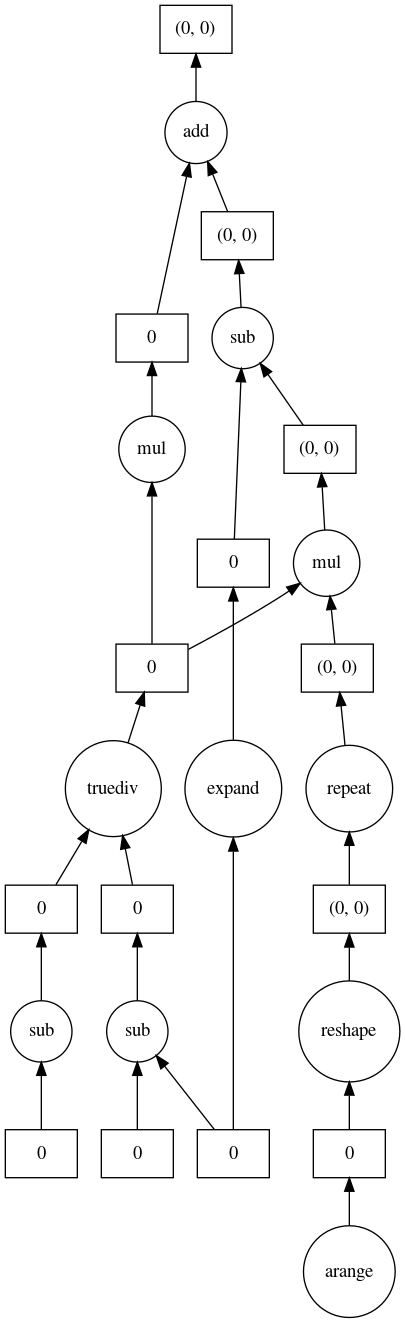

In [19]:
out_height.visualize()

## Read waveform and ancillary metrics

In [8]:
# Only read what we need - note that rh100 is in units of cm
dataset_l = ['shot_number', 'rh100', 'omega', 'rossg', 'l2b_quality_flag', 
                'pgap_theta_error', 'geolocation/local_beam_elevation']
l2b_data = l2b_f.read_shots(beam, dataset_list=dataset_l)

# Get the index of all quality shots
idx, = numpy.nonzero(l2b_data['l2b_quality_flag'])

# Use pandas to make it print nice
df = pandas.DataFrame(l2b_data)
df

,shot_number,rh100,omega,rossg,l2b_quality_flag,pgap_theta_error,local_beam_elevation
0,20421100100000001,0,1.0,0.5,0,-9999.000000,1.558602
1,20421100300000002,288,1.0,0.5,0,0.000114,1.558590
2,20421100500000003,288,1.0,0.5,0,0.000178,1.558589
3,20421100700000004,299,1.0,0.5,0,0.000056,1.558589
4,20421100900000005,292,1.0,0.5,0,0.000096,1.558589
...,...,...,...,...,...,...,...
343166,20421123300343167,322,1.0,0.5,0,0.000025,1.553505
343167,20421123500343168,306,1.0,0.5,0,0.000011,1.553504
343168,20421123700343169,318,1.0,0.5,0,0.000028,1.553504
343169,20421123900343170,336,1.0,0.5,0,0.000141,1.553504


In [15]:
import numpy as np

In [25]:
x = np.array([np.random.rand(10)])
x.max()

0.8822995549833164

In [42]:
import dask.array as da

In [43]:
x = da.from_array(l2b_data)
x

dask.array<array, shape=(343171,), dtype=[('shot_number', '<u8'), ('rh100', '<i2'), ('omega', '<f4'), ('rossg', '<f4'), ('l2b_quality_flag', 'u1'), ('pgap_theta_error', '<f4'), ('local_beam_elevation', '<f4')], chunksize=(343171,), chunktype=numpy.ndarray>

In [44]:
x.shape

(343171,)

In [ ]:
ddf = dd.from_array(l2b_data)
ddf.tail()

## Plot example vertical plant profiles

In [ ]:
%matplotlib inline

def update(index=0):
    i = idx[index]
    
    err = l2b_data['pgap_theta_error'][i]
    rh100 = l2b_data['rh100'][i] / 100
        
    cover_z, pai_z, pavd_z = get_vertical_profiles(pgap_theta_z[:,i], height[:,i], 
        l2b_data['local_beam_elevation'][i], l2b_data['rossg'][i], l2b_data['omega'][i])
    cover_z0, pai_z0, pavd_z0 = get_vertical_profiles(pgap_theta_z[:,i]-err, height[:,i], 
        l2b_data['local_beam_elevation'][i], l2b_data['rossg'][i], l2b_data['omega'][i])
    cover_z1, pai_z1, pavd_z1 = get_vertical_profiles(pgap_theta_z[:,i]+err, height[:,i], 
        l2b_data['local_beam_elevation'][i], l2b_data['rossg'][i], l2b_data['omega'][i])
    
    first_canopy = numpy.argwhere(pgap_theta_z[:,i] < 1)[0][0]
    max_height = height[first_canopy,i]
    peak_canopy = numpy.argmax(pavd_z)
    peak_height = height[peak_canopy,i]
    
    fig,axs = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
    
    axs[0].fill_betweenx(height[:,i], pgap_theta_z[:,i]-err, pgap_theta_z[:,i]+err, 
                         facecolor='lightgrey')
    axs[0].plot(pgap_theta_z[:,i], height[:,i], color='black')
    axs[0].axhline(y=rh100, color='blue', linestyle='dashed', label='RH100')
    axs[0].axhline(y=max_height, color='darkgreen', linestyle='dashed', label='Canopy')
    axs[0].axhline(y=0, color='brown', linestyle='dashed', label='Ground')
    axs[0].legend(loc='upper right')
    
    axs[1].fill_betweenx(height[:,i], cover_z0, cover_z1, facecolor='lightgrey')
    axs[1].plot(cover_z, height[:,i], color='black')    
    axs[1].axhline(y=rh100, color='blue', linestyle='dashed', label='RH100')
    axs[1].axhline(y=max_height, color='darkgreen', linestyle='dashed', label='Canopy')
    axs[1].axhline(y=0, color='brown', linestyle='dashed', label='Ground')
    axs[1].legend(loc='upper right')
    
    axs[2].fill_betweenx(height[:,i], pai_z0, pai_z1, facecolor='lightgrey')
    axs[2].plot(pai_z, height[:,i], color='black')
    axs[2].axhline(y=rh100, color='blue', linestyle='dashed', label='RH100')
    axs[2].axhline(y=max_height, color='darkgreen', linestyle='dashed', label='Canopy')
    axs[2].axhline(y=0, color='brown', linestyle='dashed', label='Ground')
    axs[2].legend(loc='upper right')
    
    axs[3].fill_betweenx(height[:,i], pavd_z0, pavd_z1, facecolor='lightgrey')
    axs[3].plot(pavd_z, height[:,i], color='black')
    axs[3].axhline(y=rh100, color='blue', linestyle='dashed', label='RH100')
    axs[3].axhline(y=max_height, color='darkgreen', linestyle='dashed', label='Canopy')
    axs[3].axhline(y=0, color='brown', linestyle='dashed', label='Ground')
    axs[3].legend(loc='upper right')

    axs[0].set(xlim=(0, 1), ylim=(-2.5, height[first_canopy,i]+7.5), 
               title=r'$P_{gap} (\theta, z=0):\/$' + \
                     '{:.2f}'.format(pgap_theta_z[-1,i]),
               xlabel=r'$P_{gap} (\theta,z)$', ylabel='Height (m)')
    axs[1].set(xlim=(0, 1), xlabel='Canopy Cover Fraction (z)',
               title='CCF (z=0): {:.2f}'.format(cover_z[-1]))
    axs[2].set(xlim=(0, max(1,pai_z0[-1])), xlabel=r'$PAI (z)\/[m^{2} m^{-2}]$',
               title='PAI (z=0): {:.2f}'.format(pai_z[-1]))
    axs[3].set(xlim=(0, max(0.1,max(pavd_z0))), xlabel=r'$PAVD (z)\/[m^{2} m^{-3}]$',
               title=r'$H\/(z=max,top):\/$' + \
                     '{:.2f},{:.2f}'.format(peak_height,max_height))
    
    fig.suptitle('Vertical Plant Profiles (shot number: {:018d})'.format(l2b_data['shot_number'][i]))   
    fig.canvas.draw()
    
update(index=10542)

## Generate an interactive plot

In [ ]:
nrecords = numpy.count_nonzero(l2b_data['l2b_quality_flag'])
ipywidgets.interact(update, index=ipywidgets.IntSlider(min=0, max=nrecords-1, step=1, 
                                                       value=10542, continuous_update=False))

In [ ]:
        if not finish:
            finish = len(l2b_f.fid[beam+'/rx_sample_start_index'])

        start_indices = da.from_array(l2b_f.fid[beam+'/rx_sample_start_index'][start:finish]-1)
        counts = da.from_array(l2b_f.fid[beam+'/rx_sample_count'][start:finish])
        pgap_profile = da.from_array(l2b_f.fid[beam+'/pgap_theta_z'][start_indices[0].compute():(start_indices[-1].compute()+counts[-1].compute())])

        max_count = counts.max() + start_offset
        if minlength:
            max_count = max(minlength, max_count)
        out_shape = (max_count.compute(), len(counts))

        out_pgap_profile = da.ones(out_shape, dtype=pgap_profile.dtype)
        pgap = da.from_array(l2b_f.fid[beam+'/pgap_theta'][start:finish])
        x = da.map_blocks(_expand, pgap).compute()
        out_pgap_profile = out_pgap_profile * x
        out_pgap_profile[0:start_offset,:] = 1.0
        
        start_indices = start_indices - start_indices.min()
        pgap_profile_out = delayed(l2b_f.waveform_1d_to_2d)(start_indices, counts, pgap_profile,
                               out_pgap_profile, start_offset=start_offset)
        
        if height is True:
            height_bin0 = da.from_array(l2b_f.fid[beam+'/geolocation/height_bin0'][start:finish], chunks=(10000,))
            height_lastbin = da.from_array(l2b_f.fid[beam+'/geolocation/height_lastbin'][start:finish], chunks=(10000,))
            v = (height_bin0 - height_lastbin) / (counts - 1)

            bin_dist = da.arange(max_count).reshape([-1,1])
            x = da.map_blocks(_expand, height_bin0)
            y = da.repeat(bin_dist, len(v), axis=1)
            out_height = x-y * v + start_offset * v
            out_height

            return pgap_profile_out.compute(), out_height.compute()
        
        else:
            return pgap_profile_out.compute()